# Entitlements near bus/rail lines
* Subset: parcels that had TOC or non-TOC activity
* Using reconstructed TOC Tiers map, we assign developments to specific transit lines.
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* All entitlement activity by bus/rail line & tier
* All entitlement activity by rail line
* Which ones have seen lots of entitlements or non-TOC entitlement activity? 
* Figure out 05 notebook first, then adapt to all entitements

In [1]:
import intake
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import utils
import boto3
import xlsxwriter

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Assign entitlements to conditions

In [3]:
toc_tiers = utils.reconstruct_toc_tiers_file()

parcels = catalog.toc_parcels_with_entitlements.read().to_crs('EPSG:4326')

In [4]:
parcels_with_activity = parcels[(parcels.num_TOC > 0) | (parcels.num_nonTOC > 0)]

In [5]:
df = utils.parcels_join_toc_tiers(parcels_with_activity, toc_tiers)

In [6]:
df['ENT'] = df.num_TOC + df.num_nonTOC

## Which rule?

In [7]:
tier_1 = df[df.TOC_Tier == 1]
tier_2 = df[df.TOC_Tier == 2]
tier_3 = df[df.TOC_Tier == 3]
tier_4 = df[df.TOC_Tier == 4]

Text(0.6, -1.0, 'TOC or Non-TOC Entitlements')

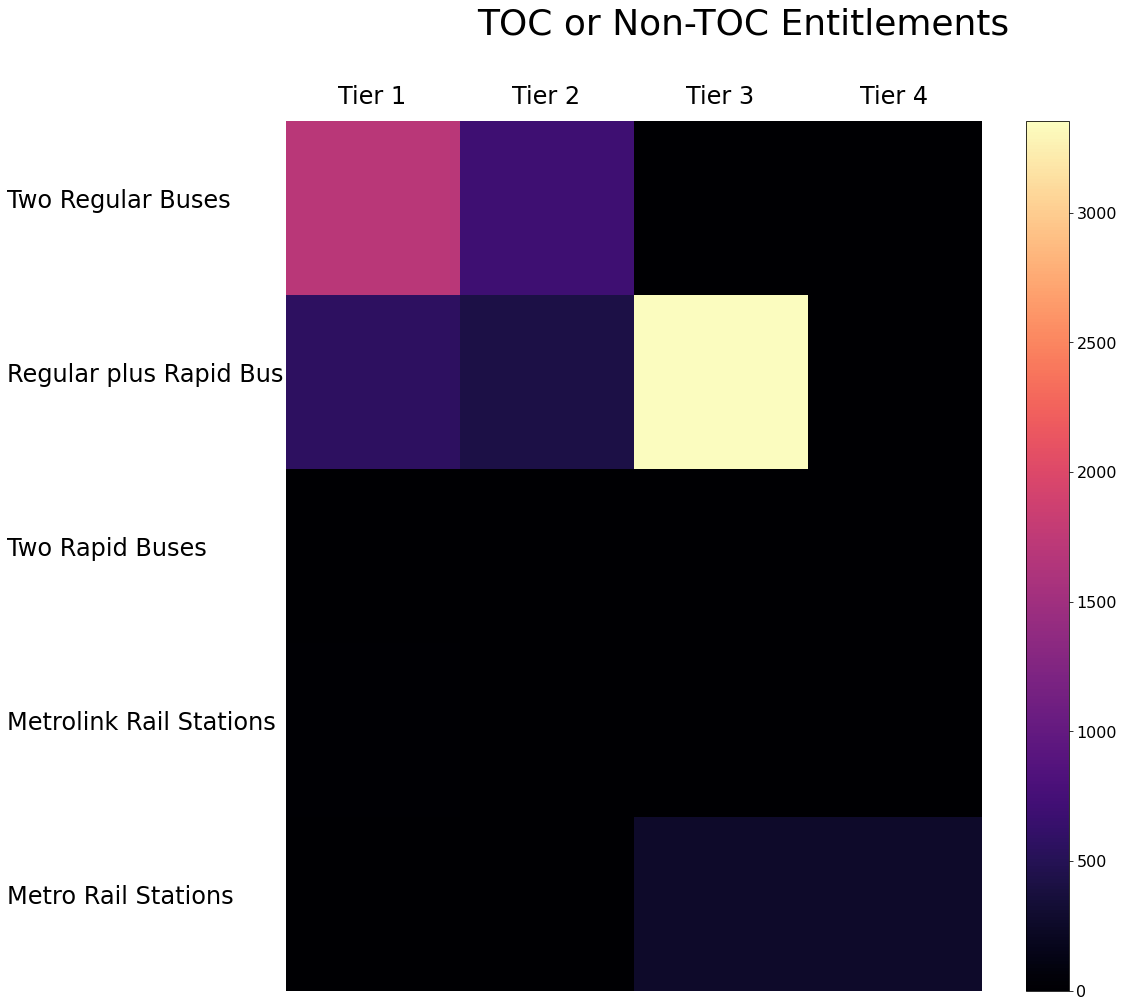

In [8]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4[(tier_4.mode_a=="metro") & (tier_4.mode_b.isin(["metro", "bus"]))].ENT.sum()
table[4,2] = tier_4[tier_4.mode_a=="metro"].ENT.sum()
table[3,2] = tier_3[tier_3.mode_a=="metrolink"].ENT.sum()
table[3,1] = tier_2[tier_2.mode_a=="metrolink"].ENT.sum()
table[3,0] = tier_1[tier_1.mode_a=="metrolink"].ENT.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].ENT.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].ENT.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].ENT.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].ENT.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].ENT.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].ENT.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].ENT.sum()


fig, ax = plt.subplots(figsize=(16,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC or Non-TOC Entitlements", fontsize=36)
#plt.savefig("toc.png", bbox_inches='tight')

## By Tier and Line

In [9]:
output_dfs = {}

def summarize(tier, header, tier_number):
    display(Markdown(header))
    metro_rail_summary = (
        tier[tier.mode_a=="metro"].groupby(["station_name", "line_name_a"])
        .agg({"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
        .sort_values(["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])
        .assign(tier = tier_number)
    )
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
        key = f'tier{tier_number}_metro'
        output_dfs[key] = metro_rail_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
        .sort_values(["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])
        .assign(tier = tier_number)
    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
        key = f'tier{tier_number}_metrolink'
        output_dfs[key] = metrolink_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])
        
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    bus_summary['tier'] = tier_number

    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["ENT", "num_TOC", "num_nonTOC"], 
                                        ascending=[False, False, False]).head(60))
        key = f'tier{tier_number}_bus'
        output_dfs[key] = bus_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])

In [10]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1.drop_duplicates(subset=["AIN"]), "## Tier 1 Statistics", 1)
summarize(tier_2.drop_duplicates(subset=["AIN"]), "## Tier 2 Statistics", 2)
summarize(tier_3.drop_duplicates(subset=["AIN"]), "## Tier 3 Statistics", 3)
summarize(tier_4.drop_duplicates(subset=["AIN"]), "## Tier 4 Statistics", 4)

## Tier 1 Statistics

#### Metrolink

,num_TOC,num_nonTOC,ENT,tier
station_name,,,,
Chatsworth Metrolink Station,0,4,4,1
Northridge Metrolink Station,0,2,2,1
Glendale Metrolink Station,0,1,1,1
Sun Valley Metrolink Station,0,1,1,1


#### Bus Lines

,num_TOC,num_nonTOC,ENT,tier
Bus Route,,,,
4,16,74,90,1
33,3,83,86,1
704,11,59,70,1
1,0,52,52,1
224,9,24,33,1
3,3,30,33,1
754,4,22,26,1
212/312,0,26,26,1
14/37,5,18,23,1


## Tier 2 Statistics

#### Bus Lines

,num_TOC,num_nonTOC,ENT,tier
Bus Route,,,,
757,9,26,35,2
207,8,25,33,2
754,12,20,32,2
4,11,21,32,2
204,11,19,30,2
704,12,17,29,2
206,11,13,24,2
200,7,17,24,2
603,4,19,23,2


## Tier 3 Statistics

#### Metro Rail

,,num_TOC,num_nonTOC,ENT,tier
station_name,line_name_a,,,,
Hollywood / Vine Station,Red,4,50,54,3
Wilshire / Vermont Station,Red/Purple,11,23,34,3
North Hollywood Station,Red,11,22,33,3
Wilshire / Normandie Station,Purple,13,15,28,3
Vermont / Sunset Station,Red,7,20,27,3
Hollywood / Highland Station,Red,0,26,26,3
Westlake / MacArthur Park Station,Red/Purple,16,5,21,3
Hollywood / Western Station,Red,4,15,19,3
Highland Park Station,Gold,0,19,19,3


#### Bus Lines

,num_TOC,num_nonTOC,ENT,tier
Bus Route,,,,
720,49,89,138,3
757,28,109,137,3
780,20,71,91,3
754,23,49,72,3
207,15,36,51,3
704,20,25,45,3
705,13,32,45,3
745,1,44,45,3
217,16,26,42,3


## Tier 4 Statistics

#### Metro Rail

,,num_TOC,num_nonTOC,ENT,tier
station_name,line_name_a,,,,
Pershing Square Station,Red/Purple,0,13,13,4
Vermont / Beverly Station,Red,8,3,11,4
Wilshire/La Brea,Purple,2,8,10,4
Wilshire / Western Station,Purple,1,9,10,4
Hollywood / Highland Station,Red,1,8,9,4
Hollywood / Vine Station,Red,0,8,8,4
Westwood/UCLA,Purple,0,8,8,4
7th St / Metro Center Station - Metro Red & Purple Lines,Red/Purple,0,7,7,4
Hollywood / Western Station,Red,0,7,7,4


#### Bus Lines

,num_TOC,num_nonTOC,ENT,tier
Bus Route,,,,
720,3,35,38,4
754,15,3,18,4
710,5,13,18,4
757,0,15,15,4
910/950,0,14,14,4
780,1,8,9,4
704,4,1,5,4
728,0,4,4,4
770,0,4,4,4


## By Line

In [11]:
def summarize(df):
    # Bus
    bus_df = df[(df.mode_a == "bus") | (df.mode_b == "bus")]

    a = bus_df[bus_df.mode_a=="bus"].groupby("line_name_a").agg(
        {"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
    b = bus_df[bus_df.mode_b=="bus"].groupby("line_name_b").agg(
        {"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )

    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["ENT", "num_TOC", "num_nonTOC"], 
                                        ascending = [False, False, False]).head(30))
        key = 'bus'
        output_dfs[key] = bus_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])
    
    # Metrolink
    metrolink_df = df[df.mode_a == "metrolink"]
    
    metrolink_summary = (
        metrolink_df.groupby(["station_name"])
        .agg({"num_TOC": "sum", "num_nonTOC":"sum", "ENT":"sum"})
        .sort_values(["ENT", "num_TOC", "num_nonTOC"], 
                                        ascending = [False, False, False])
    )
    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
        key = 'metrolink'
        output_dfs[key] = metrolink_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])

    # Metro Rail
    metro_df = df[(df.mode_a == "metro") | (df.mode_b == "metro")]

    metro_rail_summary = (
        metro_df.groupby("line_name_a")
        .agg({"num_TOC":"sum", "num_nonTOC":"sum", "ENT":"sum"})
        .sort_values(["ENT", "num_TOC", "num_nonTOC"], 
                                        ascending = [False, False, False])
    )
    metro_rail_summary = metro_rail_summary.reindex(
        index=metro_rail_summary.index.rename("Rail Line")
    )
    
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
        key = 'metro'
        output_dfs[key] = metro_rail_summary.sort_values(
            ["ENT", "num_TOC", "num_nonTOC"], ascending = [False, False, False])

In [12]:
summarize(df)

#### Bus Lines

,num_TOC,num_nonTOC,ENT
Bus Route,,,
4,119,359,478
720,102,373,475
780,88,385,473
728,47,415,462
754,135,299,434
757,119,314,433
704,118,279,397
910/950,2,389,391
745,3,324,327


#### Metrolink

,num_TOC,num_nonTOC,ENT
station_name,,,
Van Nuys Metrolink Station,4,0,4
Chatsworth Metrolink Station,0,4,4
Glendale Metrolink Station,0,4,4
Northridge Metrolink Station,0,2,2
Sun Valley Metrolink Station,0,1,1


#### Metro Rail

,num_TOC,num_nonTOC,ENT
Rail Line,,,
Purple,129,389,518
Red,125,384,509
Red/Purple,53,423,476
Blue/EXPO,2,171,173
Regional Connector,0,167,167
Gold,16,143,159
EXPO,49,75,124
Blue,2,50,52
Crenshaw,26,21,47


## Export output -- need to adapt for all ENT

In [13]:
bus_by_tier = pd.concat([
    output_dfs['tier1_bus'], 
    output_dfs['tier2_bus'], 
    output_dfs['tier3_bus'],
    output_dfs['tier4_bus'],
], axis = 0, sort = False).reset_index()

In [14]:
bus_by_tier.head()

,Bus Route,num_TOC,num_nonTOC,ENT,tier
0,4,16,74,90,1
1,33,3,83,86,1
2,704,11,59,70,1
3,1,0,52,52,1
4,224,9,24,33,1


In [15]:
bus_total = (
    bus_by_tier.groupby('Bus Route')
    .agg({'ENT':'sum'})
    .reset_index()
    .rename(columns = {'ENT':'line_ENT'})
)

bus_by_tier = pd.merge(bus_by_tier, bus_total, on = 'Bus Route', how = 'left')

bus_by_tier['pct_ENT'] = bus_by_tier.ENT / bus_by_tier.line_ENT

bus_by_tier = bus_by_tier.sort_values(['line_ENT', 'ENT'], ascending = [False, False])

In [16]:
metro_by_tier = pd.concat([
    output_dfs['tier3_metro'], 
    output_dfs['tier4_metro'], 
], axis = 0, sort = False).reset_index()

In [17]:
metro_total = (
    metro_by_tier.groupby(['line_name_a'])
    .agg({'ENT':'sum'})
    .reset_index()
    .rename(columns = {'ENT':'line_ENT'})
)

metro_by_tier = pd.merge(metro_by_tier, metro_total, on = 'line_name_a', how = 'left')

metro_by_tier['pct_ENT'] = metro_by_tier.ENT / metro_by_tier.line_ENT

metro_by_tier = metro_by_tier.sort_values(['line_ENT', 'ENT'], ascending = [False, False])

In [18]:
writer = pd.ExcelWriter('../outputs/06-ent-line-analysis.xlsx', engine='xlsxwriter')

bus_by_tier.to_excel(writer, sheet_name = 'bus_by_tier')
metro_by_tier.to_excel(writer, sheet_name = 'metro_by_tier')

for key, value in output_dfs.items():
    if key.find('tier') is -1:
        value.to_excel(writer, sheet_name = key)

writer.save()